In [1]:
from pprint import pprint as pprint
import numpy as np
import matplotlib.pyplot as plt

import control as pc

%pylab inline

import pandas as pd

from sysident import loadtools

import scipy as sp
import numpy.linalg as la


Populating the interactive namespace from numpy and matplotlib


In [2]:
folder = "/home/lth/jupyter_nb/optimization/models/"
#fname = folder+"ss1_20180724-082630_poles2_ident_pade1_0:036_control_20180724-092309.npy"
#fname = folder+"ss2_20180724-082631_poles3_ident_pade2_0:036_control_20180724-092409.npy"
#fname = folder+"ss3_position_20180717-104106_poles3_ident_pade1_0:032_control_20180724-092445.npy"
fname = folder+"ss5_20180724-082628_poles3_ident_pade1_0:032_control_20180724-092522.npy"
#fname = folder+"ss6_20180724-082629_poles4_ident_pade2_0:032_control_20180724-092618.npy"

res, _ = loadtools.loadNPY(fname)
pprint(res.keys())

['A',
 'Ck',
 'C',
 'B',
 'ro',
 'D',
 'plot_input_step',
 'ni',
 'plot_control_step_s',
 'Ak',
 'plot_control_step_y',
 'u_max',
 'plot_control_step_u',
 'Ek',
 'plot_model_step',
 'plot_control_step_delay_u',
 'delay',
 'plot_control_step_delay_y',
 'X0',
 'Bk',
 'Dk']


poles [-5.66647058e+05 -1.96085217e+01]
A = [[      0.           -1111.11111111]
 [  10000.         -566666.66666667]]

B = [[-1111.11111111]
 [    0.        ]]

C = [[ 0. -1.]]

D = [[0.]]



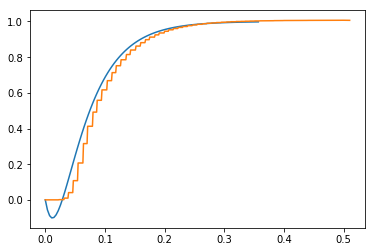

17.475616549353035


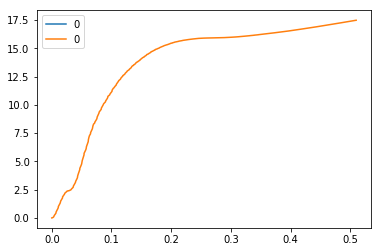

In [26]:
#1.00807778e+00 8.44491407e+01 3.30837215e-04 4.67498491e-02

K = 1
D = 85
T = 3e-04

Td = 4e-02
Td_o = 1

sys0 = pc.tf([K],[T**2, 2*D*T, 1])
sys = pc.series(pc.tf(*pc.pade(Td, Td_o)), sys0)

t, y = pc.step_response(sys)
print "poles", pc.pole(sys0)

print pc.tf2ss(sys0)

plt.plot(t, y)

#plt.plot(*pc.step_response(sys))
#plt.plot(*res['plot_model_step'])

plt.plot(*res['plot_input_step'])

plt.show()


df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
df2 = pd.DataFrame(y, index=t)

df3 = pd.concat([df1, df2], axis=1).interpolate()

#df3.diff(axis=1).plot()
df3.diff(axis=1).abs().cumsum().plot()
#plt.plot(res['plot_input_step'][0])
print np.array(df3.diff(axis=1).abs().cumsum())[-1][1]

In [4]:
# Creates a PT2+delay system from parameters
def get_systems(K, T, D, Td, Td_o=1):
    sys0 = pc.tf([K],[T**2, 2*D*T, 1])
    sys = pc.series(pc.tf(*pc.pade(Td, Td_o)), sys0)
    return sys0, sys

In [23]:
from scipy.optimize import minimize

pole_limit = -100

# Optimization function:
# creates PT2-d system, transforms to modal form,
# recreates A with idealized A (eye*eigval)
# ma
def fun(arg, Td_o=1, show=False):
    
    K, D, T, Td = arg
    #print K, D, T, Td
    #T = np.abs(T)
    
    sys0, sys = get_systems(K, T, D, Td, Td_o)
    
    ss = pc.tf2ss(sys)
    
    eigval, Tzx = la.eig(ss.A)
    A_modal = la.solve(Tzx, ss.A).dot(Tzx)
    B_modal = la.solve(Tzx, ss.B)
    C_modal = ss.C.dot(Tzx)
    D_modal = ss.D
    
    t, y = pc.step_response(pc.ss(np.eye(len(eigval))*eigval, B_modal, C_modal, D_modal))
    
    df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
    df2 = pd.DataFrame(y, index=t).fillna(np.inf)
    #print df2
    df3 = pd.concat([df1, df2], axis=1).interpolate()
    
    df_diff = df3.diff(axis=1).iloc[:,1]
    #print np.array(df_diff.cumsum().tail(), dtype=float64)

    poles = pc.pole(pc.ss(np.eye(len(eigval))*eigval, B_modal, C_modal, D_modal))
    #print poles[poles < -pole_limit]
    #print poles.min()
    p = np.sum(np.power(poles[poles < pole_limit], 10))
    #print poles
    #print p
    
    r = np.array(df3.diff(axis=1).abs().cumsum())[-1][1]
    
    if np.isnan(r):
        r = np.inf
    
    if show:
        plt.plot(t, y)
        plt.plot(*res['plot_input_step'])
        plt.show()

        df_diff.plot()
        print r+p, '>>', arg
    return r+p

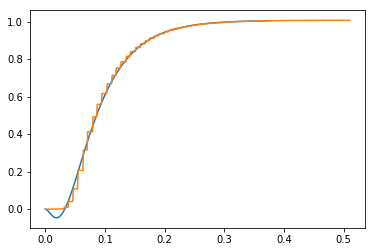

4.853596064383138 >> [1.00680139 1.21122069 0.02839508 0.03305889]
[-66.72407321 -60.49809887 -18.58794127]


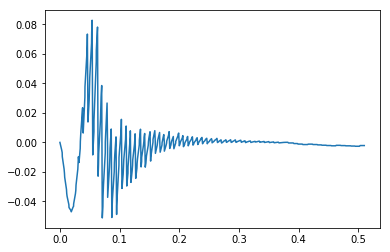

In [24]:
result = minimize(fun, [1, 1, 0.1, 0.1], method='Powell')
fun(result.x, show=True)

K, D, T, Td = result.x
#Td_o = 1 !!!!!!!!!!!!!!!!
sys0, sys = get_systems(K, T, D, Td, Td_o=1)
ss = pc.tf2ss(sys)
eigval, Tzx = la.eig(ss.A)
A_modal = la.solve(Tzx, ss.A).dot(Tzx)
B_modal = la.solve(Tzx, ss.B)
C_modal = ss.C.dot(Tzx)
D_modal = ss.D

print pc.pole(sys)

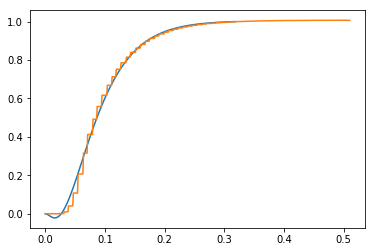

6.372395763674492 >> [1.00452171 1.02136923 0.03695103 0.02427773]
[-82.38003554 -33.26574298 -22.01656864]


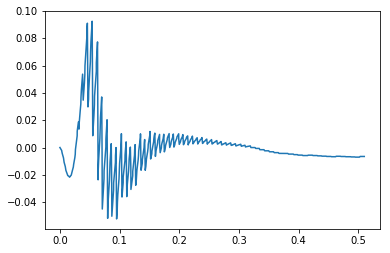

In [7]:
result = minimize(fun, [1, 1, 0.1, 0.1], method='Nelder-Mead')
fun(result.x, show=True)

K, D, T, Td = result.x
#Td_o = 1 !!!!!!!!!!!!!!!!
sys0, sys = get_systems(K, T, D, Td, Td_o=1)
ss = pc.tf2ss(sys)
eigval, Tzx = la.eig(ss.A)
A_modal = la.solve(Tzx, ss.A).dot(Tzx)
B_modal = la.solve(Tzx, ss.B)
C_modal = ss.C.dot(Tzx)
D_modal = ss.D

print pc.pole(sys)

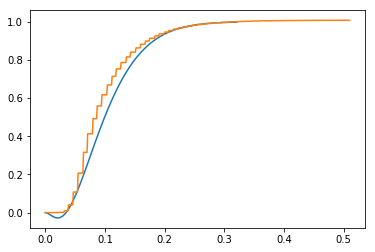

16.406335481286547


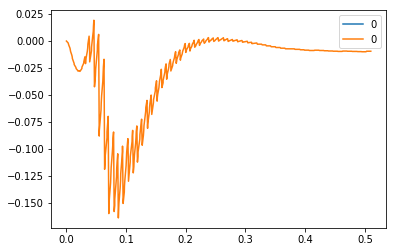

In [8]:
df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
df2 = pd.DataFrame(res['plot_model_step'][1], index=res['plot_model_step'][0])

df3 = pd.concat([df1, df2], axis=1).interpolate()

plt.plot(*res['plot_model_step'])
plt.plot(*res['plot_input_step'])
plt.show()

df3.diff(axis=1).plot()
r = np.array(df3.diff(axis=1).abs().cumsum())[-1][1]
print r

In [9]:
K, D, T, Td = result.x

#Td_o = 1 !!!!!!!!!!!!!!!!
sys0, sys = get_systems(K, T, D, Td)
ss = pc.tf2ss(sys)


In [10]:
eigval, Tzx = la.eig(ss.A)
print eigval
print Tzx

[-22.01656864 -33.26574298 -82.38003554]
[[ 0.17643553  0.12448615 -0.06396601]
 [ 0.74455474  0.71653236 -0.4828237 ]
 [-0.64382353 -0.68635601  0.87337828]]


In [11]:
A_modal = la.solve(Tzx, ss.A).dot(Tzx)
B_modal = la.solve(Tzx, ss.B)
C_modal = ss.C.dot(Tzx)
D_modal = ss.D

In [12]:
print A_modal
print np.eye(3)*eigval

print np.eye(3)*eigval - A_modal

[[-2.20165686e+01  2.70914071e-13 -3.19905710e-13]
 [-3.15819159e-13 -3.32657430e+01  4.67089696e-13]
 [-4.68054563e-14 -7.11807135e-14 -8.23800355e+01]]
[[-22.01656864  -0.          -0.        ]
 [ -0.         -33.26574298  -0.        ]
 [ -0.          -0.         -82.38003554]]
[[-2.55795385e-13 -2.70914071e-13  3.19905710e-13]
 [ 3.15819159e-13  3.69482223e-13 -4.67089696e-13]
 [ 4.68054563e-14  7.11807135e-14 -1.13686838e-13]]


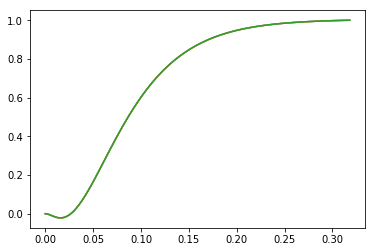

In [13]:
plt.plot(*pc.step_response(ss))
plt.plot(*pc.step_response(pc.ss(A_modal, B_modal, C_modal, D_modal)))
plt.plot(*pc.step_response(pc.ss(np.eye(3)*eigval, B_modal, C_modal, D_modal)))

In [ ]:
fname = 'ss_{}_poles{}_manual_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(pc.pole(sys)), 'pade{}_{}'.format(Td_o, Td))


loadtools.saveDelayModel(fname, ss.A, ss.B, ss.C, ss.D, Td)